In [1]:
import sys
sys.path.append('/home/kboone/software/Galaxy_Bias/Bispectrum/Convert_Bispectrum/')

import jax
import h5py
import optax
import numpy as np
import pandas as pd
import jax.numpy as jnp
from Fits_Helpers import *
from Visual_Helpers import *
from scipy.linalg import block_diag
from scipy.interpolate import CubicSpline as spline

jax.config.update("jax_enable_x64", True) 

In [2]:
phases = 25

all_pos = []

for ph in np.arange(phases):
    pos_file = '../../Data/7E10_Gala_z8_Positions/Gala_ph0' + '{:02d}'.format(ph) + '.h5'
    
    with h5py.File(pos_file, 'r') as f_:
        dset = f_['dataset']
        pos = dset[:].T
        all_pos.append(len(pos))

all_pos = np.array(all_pos)

In [6]:
data = []
for ph in np.arange(phases):
    data.append(np.load('Fits/Both_Fit_History_'+str(ph)+'.npy'))
data = np.array(data)

In [7]:
data.shape

(25, 100001, 7)

In [8]:
np.save('Fits_z5/Both_Fit_History.npy', data)

In [11]:
np.average(all_pos)

np.float64(1517252.96)

In [5]:
np.std(all_pos)

np.float64(19975.228616023396)

In [20]:
# All purpose parameters
L = 2000
V = L**3
N_grid = 256
N_tsc = 2048
kF = 2*np.pi/L
kN_tsc = N_tsc*np.pi/L
kN = N_grid*np.pi/L

phases = 25

noises = np.zeros(phases, dtype=np.float64)

for ph in np.arange(phases):
    pos_file = '../../Data/Gala_z8_Positions/Gala_ph0' + '{:02d}'.format(ph) + '.h5'
    
    with h5py.File(pos_file, 'r') as f_:
        dset = f_['dataset']
        pos = dset[:].T
        noises[ph] = L**3/len(pos)


def W(k):
    return (np.sin(np.pi*k/(2*kN_tsc)) / (np.pi*k/(2*kN_tsc)))**3

In [21]:
# Power spectrum data
kMax_P = kN

numBins = 10
kBins = np.geomspace(kF, kMax_P, numBins + 1)

P_bins = []
for ph in np.arange(phases):
    power_file = '/mnt/nvme1/kboone/Data/BigFiles/Gala_8/Gala_ph0' + '{:02d}'.format(ph) + '/Gala_256_ps.dat'
    P_bins_ind, kP, bin_idx, mask_P, N_P, N_P_tot = data_power(power_file, kBins, numBins)
    P_bins.append(P_bins_ind)

P_bins = np.array(P_bins)
std_P_bins = np.std(P_bins, axis=0, ddof=1)

C_P = np.cov(P_bins/std_P_bins, rowvar=False)
C_inv_P = np.linalg.inv(C_P) * (phases - numBins - 2) / (phases - 1)

Wk = W(kP)

In [22]:
b1b1_file = '/mnt/nvme1/kboone/Sims/PowerSpectra/b1b1_ps.dat'
b1b1_unbinned, b1b1 = sims_power(b1b1_file, kBins, numBins, Wk)

b2b2_file = '/mnt/nvme1/kboone/Sims/PowerSpectra/b2b2_ps.dat'
b2b2_unbinned, b2b2 = sims_power(b2b2_file, kBins, numBins, Wk)

b3b3_file = '/mnt/nvme1/kboone/Sims/PowerSpectra/b3b3_ps.dat'
b3b3_unbinned, b3b3 = sims_power(b3b3_file, kBins, numBins, Wk)

b2K2_file = '/mnt/nvme1/kboone/Sims/PowerSpectra/b2K2_ps.dat'
b2K2_unbinned, b2K2 = sims_power(b2K2_file, kBins, numBins, Wk, sym_factor=2)

b2F2_file = '/mnt/nvme1/kboone/Sims/PowerSpectra/b2F2_ps.dat'
b2F2_unbinned, b2F2 = sims_power(b2F2_file, kBins, numBins, Wk, sym_factor=2)

P1 = spline(kP, b1b1_unbinned, bc_type='natural')
P2 = spline(kP, b2b2_unbinned, bc_type='natural')
P3 = spline(kP, b3b3_unbinned, bc_type='natural')
PK = spline(kP, b2K2_unbinned, bc_type='natural')
PF = spline(kP, b2F2_unbinned, bc_type='natural')

In [5]:
# Bispectrum data
max_ksum = kN
min_ksum = max_ksum/4

min_k = 0.5*kF
max_k = 64.5*kF
Bs = []

for ph in np.arange(phases):
    bs_file = '/mnt/nvme1/kboone/Data/BigFiles/Gala_8/Gala_ph0' + '{:02d}'.format(ph) + '/Gala_256_comb.dat'
    B, kB = data_bispec(bs_file, min_k, max_k, min_ksum, max_ksum)
    Bs.append(B)

Bs = np.array(Bs)
# Whiten by dividing by standard deviations first.
std_B = np.std(Bs, axis=0, ddof=1)
C_B = np.cov(Bs/std_B, rowvar=False)
C_inv_B = np.diag(1/np.diag(C_B))

k1, k2, k3 = kB[:,0], kB[:,1], kB[:,2]

W1 = W(k1)
W2 = W(k2)
W3 = W(k3)

In [6]:
b1b1b2_file = '/mnt/nvme1/kboone/Sims/Bispectra/b1b1b2_comb.dat'
b1b1b2 = sims_bispec(b1b1b2_file, kB, sym_factor = 3) * W1*W2*W3

b2b2b2_file = '/mnt/nvme1/kboone/Sims/Bispectra/b2b2b2_comb.dat'
b2b2b2 = sims_bispec(b2b2b2_file, kB, sym_factor = 1) * W1*W2*W3

b1b2b3_file = '/mnt/nvme1/kboone/Sims/Bispectra/b1b2b3_comb.dat'
b1b2b3 = sims_bispec(b1b2b3_file, kB, sym_factor = 6) * W1*W2*W3

b1b1K2_file = '/mnt/nvme1/kboone/Sims/Bispectra/b1b1K2_comb.dat'
b1b1K2 = sims_bispec(b1b1K2_file, kB, sym_factor = 3) * W1*W2*W3

b1b1F2_file = '/mnt/nvme1/kboone/Sims/Bispectra/b1b1F2_comb.dat'
b1b1F2 = sims_bispec(b1b1F2_file, kB, sym_factor = 3) * W1*W2*W3

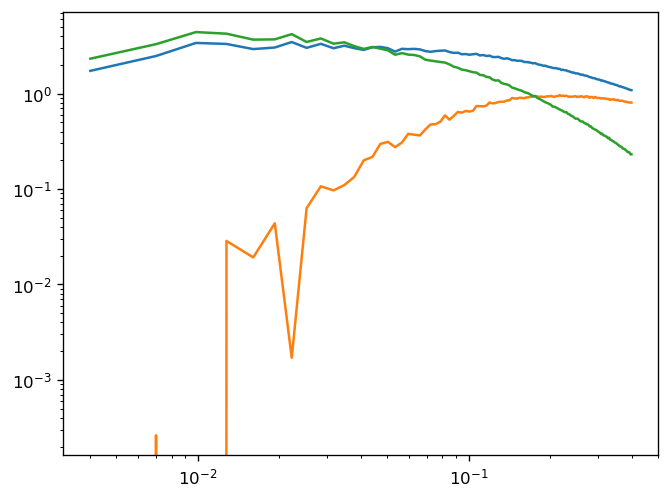

In [25]:
import matplotlib.pyplot as plt

plt.figure(dpi = 120)
plt.plot(kP, b2b2_unbinned)
plt.plot(kP, b2F2_unbinned)
plt.plot(kP, b2K2_unbinned)
plt.yscale('log')
plt.xscale('log')
plt.show()